In [64]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad
from autograd import hessian

from scipy import optimize as opt
from scipy.linalg import det

from IPython import display
%matplotlib inline

# Revisiting the Saddlepoint Approximation
#### by [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/)  

### 1.  Sample Data
Define function to sample from a Gaussian mixture...

In [65]:
# Draw sample from mixture model
# k ~ Mult(pi)
# z ~ f_k
def draw_samples(pi_arr, mu_arr, cov_arr, n_samples=100):
    comp_arr = np.random.multinomial(n_samples, pi_arr)
    z = []
    y = []
    for idx, count in enumerate(comp_arr):
        for c in range(count):
            y.append(idx)
            z.append(np.random.multivariate_normal(mu_arr[idx], cov_arr[idx]))
    return np.array(z), np.array(y)[np.newaxis].T


def plot_densities(true_data, samples=np.array([])):
    # clear the plot
    display.clear_output(wait=True)

    plt.scatter(true_data[:,0], true_data[:,1], s=100, color='k', marker='x', label="data")
    
    if samples.shape[0] > 0:
        plt.scatter(samples[:,0], samples[:,1], s=100, color='r', marker='o', label="samples")
        
    plt.legend(loc=2)
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    
    #plt.xlabel("X1")
    #plt.ylabel("X2")
    
    plt.show()

    
def shuffle_in_unison_inplace(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

Sample data $\mathbf{X} = \{\mathbf{x}_{1}, \ldots, \mathbf{x}_{N} \}$ from the mixture density $$\mathbf{x} \sim .5 * \text{N}(\boldsymbol{\mu}=[-4,-4], \mathbb{I}) + .5 * \text{N}(\boldsymbol{\mu}=[4,4], \mathbb{I}).$$

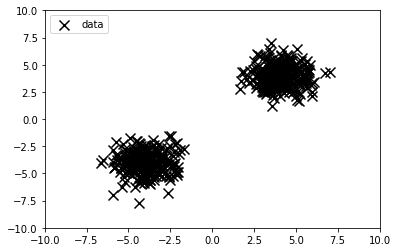

In [66]:
N = 500 # number of datapoints 
input_d = 2

# Define mixture model
pi = np.array([.5, .5])
mu_s = [np.array([-4., -4.]), np.array([4., 4.])]
cov_s = [np.array([[1., 0.], [0., 1.]]), np.array([[1., 0.], [0., 1.]])]

# draw_samples
X_train, y_train = draw_samples(pi, mu_s, cov_s, N)

# shuffle 
X_train, y_train = shuffle_in_unison_inplace(X_train,y_train)

plot_densities(X_train) 

### 2.  Computing the Saddlepoint Density
Define functions for the empirical MGF, saddlepoint equation ($\frac{\partial}{\partial \boldsymbol{\lambda}_{0} } \log \mathcal{M}_{X}(\boldsymbol{\lambda}_{0}) - \mathbf{x}_{0} = 0$), and the saddlepoint density...

In [67]:
def empirical_MGF(t, data, a=0.):
    return np.mean([np.exp(np.dot(t, x) - a) for x in data])

dLogM_dt = grad(lambda t, data: np.log(empirical_MGF(t, data)))
d2LogM_dt2 = hessian(lambda t, data: np.log(empirical_MGF(t, data)))

def saddlepoint_equation(t, x0, data):
    return np.mean((dLogM_dt(t, data) - x0)**2)

def log_saddlepoint_density(x, data, eps=1e-8):
    # solve for t
    result = opt.minimize(fun=saddlepoint_equation, x0=[0., 0.], args=(x, data))
    t0 = result.x
    a_max = np.dot(np.max(data,axis=0), t0)
    
    # calculate hessian
    hess = np.nan_to_num(d2LogM_dt2(t0, data))
    det_hess = det(hess + .0001*np.eye(input_d))
    
    return -.5 * np.log(2*np.pi*det_hess + eps) + np.log(empirical_MGF(t0, data, a_max) + eps) + a_max - np.dot(t0, x)

Compute the (log) saddlepoint density for a grid of points...

In [68]:
X = np.linspace(-6, 6, 2)
Y = np.linspace(-6, 6, 2)
X, Y = np.meshgrid(X, Y)
x = X.ravel()
y = Y.ravel()

Z = []
for idx in range(x.shape[0]):
    x0 = np.array([x[idx], y[idx]])
    Z.append(log_saddlepoint_density(x0, X_train))
    
Z = np.nan_to_num(np.array(Z)).reshape(X.shape)

Plot the resulting density...

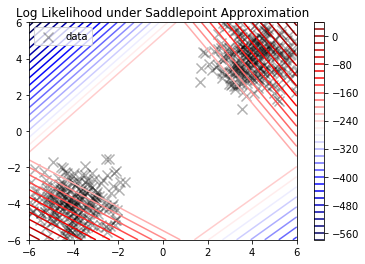

In [69]:
plt.contour(X, Y, Z, 40, cmap='seismic')
plt.colorbar()
plt.scatter(X_train[:,0], X_train[:,1], s=100, color='k', marker='x', alpha=.3, label="data")

plt.title("Log Likelihood under Saddlepoint Approximation")

plt.legend(loc=2)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.show()

### Estimating an Implicit Generative Model
First, implement some basic functions and define variables...

In [70]:
import tensorflow as tf

def init_neural_net(layer_sizes, std=.1):
    # layer_sizes is a list of the input size, hidden layer sizes, and output size
    params = {'w':[], 'b':[]}
    for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        params['w'].append(tf.Variable(tf.random_normal([n_in, n_out], stddev=std)))
        params['b'].append(tf.Variable(tf.zeros([n_out,])))
    return params

def neural_net(X, params):
    h = [X]
    for w,b in zip(params['w'][:-1], params['b'][:-1]):
        h.append( tf.nn.relu( tf.matmul(h[-1], w) + b ) )
    # NOTE: no output activation.  TF will take care of this in pre-defined loss functions
    return tf.matmul(h[-1], params['w'][-1]) + params['b'][-1]


### dimensionalities
input_d = 2
latent_d = 50 # z ~ p(z), prior
hidden_d = 500 # num. of hidden units in NN

### Make symbolic variables
X = tf.placeholder("float", [None, input_d]) # samples to discriminate
Z = tf.placeholder("float", [None, latent_d]) # samples from generator's latent space

Define the two networks: the generator and regressor for saddlepoint equation...

In [71]:
# define generator network
generator_params = init_neural_net([latent_d, hidden_d, input_d])
generator_out = neural_net(Z, generator_params)

# define saddlepoint regression function (for amortization)
tFn_params = init_neural_net([input_d, hidden_d, input_d])
t_out = neural_net(generator_out, tFn_params)

Implement the saddlepoint objective...

In [72]:
# calculate empirical MGF
a = tf.stop_gradient(tf.reduce_sum(tf.matmul(tf.reduce_max(X, axis=0, keep_dims=True), tf.transpose(t_out))))
log_empirical_MGF = tf.log(tf.reduce_mean(tf.exp(tf.matmul(X, tf.transpose(t_out)) - a))) + a

# objective for saddle point equation
dLogM_dt = tf.reduce_mean(tf.multiply(tf.exp(tf.matmul(X, tf.transpose(t_out))), X) / tf.exp(log_empirical_MGF), axis=0, keepdims=True)
saddlepoint_equation = tf.reduce_mean((dLogM_dt - generator_out)**2)

# objective for generator network
d2LogM_dt2 = tf.gradients(tf.reduce_sum(dLogM_dt), t_out)[0]
diag_hess_det = tf.reduce_prod(d2LogM_dt2)
log_saddlepoint_density = tf.reduce_sum(-.5*tf.log(diag_hess_det) + log_empirical_MGF - tf.matmul(generator_out, tf.transpose(t_out)))

Now lets train the implicit generative model...

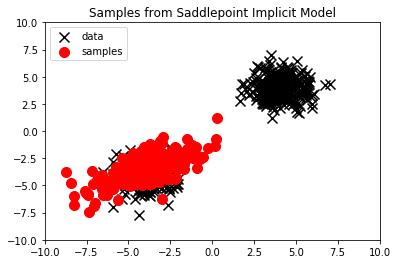

0.047214556428728974
-2.604939725467137


In [73]:
# Set training params
n_epochs = 10
n_discrim_updates = 10
n_generator_updates = 7
learning_rate = 0.000007

# create training ops
train_genModel = tf.train.AdamOptimizer(learning_rate).minimize(-log_saddlepoint_density, var_list=generator_params['w']+generator_params['b'])
train_saEq = tf.train.AdamOptimizer(learning_rate).minimize(saddlepoint_equation, var_list=tFn_params['w']+tFn_params['b'])

with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch_idx in range(n_epochs):
        
        # train saddlepoint solver
        saEq_error = 0.
        for idx in range(n_discrim_updates):
            prior_samples = np.random.normal(size=(N, latent_d))
            for n in range(N):
                z = prior_samples[idx, :][np.newaxis]
                _, err = session.run([train_saEq, saddlepoint_equation], feed_dict={Z: z, X: X_train})
                saEq_error += err
        saEq_error /= (N*n_discrim_updates)
        
        # train generator network
        logSAProb = 0.
        for idx in range(n_generator_updates):
            # sample from latent space
            prior_samples = np.random.normal(size=(N, latent_d))

            # perform update
            for n in range(N):
                z = prior_samples[idx, :][np.newaxis]
                _, err = session.run([train_genModel, log_saddlepoint_density], feed_dict={Z: z, X: X_train})
                logSAProb += err
        logSAProb /= (N*n_generator_updates)
                
        # visualize progress
        #if epoch_idx%5 == 0:
        plt.title("Samples from Saddlepoint Implicit Model")
        plot_densities(X_train, session.run(generator_out, feed_dict={Z: np.random.normal(size=(int(N/2), latent_d))}))
        
        print(saEq_error)
        print(logSAProb)

### Saddlepoint Variational Inference for VAEs
First, define the VAE...

In [74]:
eps = 1e-8

mu_prior=0.
sigma_prior=1.

input_d = 2
latent_d = 50 # z ~ p(z), prior
hidden_d = 500 # num. of hidden units in NN

### Make symbolic variables
X = tf.placeholder("float", [None, input_d]) # samples to discriminate

# Define Encoder
encoder_params = init_neural_net([input_d, hidden_d])
mu_params = init_neural_net([hidden_d, latent_d])
logSig_params = init_neural_net([hidden_d, latent_d])

encoder_out = tf.nn.relu(neural_net(X, encoder_params))
mu = neural_net(encoder_out, mu_params)
logSig = neural_net(encoder_out, logSig_params)
sigma = tf.exp(logSig)

# Non-Centered Parametrization
z = mu + tf.multiply(sigma, tf.random_normal(shape=tf.shape(mu)))

# Define Decoder
decoder_params = init_neural_net([latent_d, hidden_d, input_d])
decoder_out = neural_net(z, decoder_params)

# Define Likelihood Prob
gauss_log_likelihood = tf.reduce_sum(-.5*(decoder_out - X)**2, reduction_indices=1, keepdims=True)

# Define KLD function
d = (mu - mu_prior)
d = tf.multiply(d,d)
gauss2gauss_KLD = -.5 * tf.reduce_mean(-tf.divide(d + tf.multiply(sigma, sigma), sigma_prior*sigma_prior) \
            - 2*tf.log(sigma_prior) + 2.*logSig + 1., reduction_indices=1, keepdims=True)

Next define the functions for the saddlepoint approximation...

In [75]:
# Define Regression Function for MGF input
tFn_params = init_neural_net([input_d, hidden_d, input_d])
t_out = neural_net(X, tFn_params)

# calculate empirical MGF
a = tf.stop_gradient(tf.reduce_sum(tf.matmul(tf.reduce_max(X, axis=0, keepdims=True), tf.transpose(tf.reduce_max(t_out, axis=0, keepdims=True)))))
log_empirical_MGF = tf.log(tf.reduce_sum(tf.exp(gauss_log_likelihood + tf.reduce_sum(tf.multiply(X, t_out), axis=1, keepdims=True) - a)) + eps) + a

# objective for saddle point equation
dLogM_dt = tf.reduce_sum(tf.multiply(tf.exp(gauss_log_likelihood + tf.reduce_sum(tf.multiply(X, t_out), axis=1, keepdims=True)), X) / tf.exp(log_empirical_MGF), axis=0, keepdims=True)
saddlepoint_equation = tf.reduce_mean((dLogM_dt - X)**2)

# objective for variational inference
d2LogM_dt2 = tf.gradients(tf.reduce_sum(dLogM_dt), t_out)[0]
diag_hess_det = tf.reduce_prod(d2LogM_dt2)
log_saddlepoint_density = tf.reduce_sum(-.5*tf.log(diag_hess_det + eps) + log_empirical_MGF - gauss2gauss_KLD - tf.reduce_sum(tf.multiply(X, t_out), axis=1, keepdims=True) )

Now lets train the VAE...

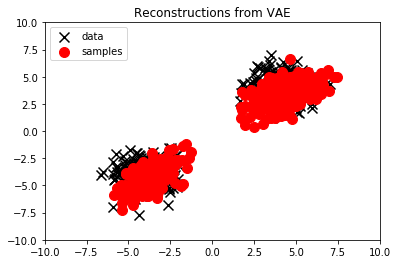

17.143156337738038
7.98878280711174


In [76]:
# Set training params
n_epochs = 15
n_discrim_updates = 20 
n_generator_updates = 10

sa_learning_rate = .0003
vi_learning_rate = 0.0000007

# create training ops
train_genModel = tf.train.AdamOptimizer(vi_learning_rate).minimize(-log_saddlepoint_density, var_list=decoder_params['w']+decoder_params['b']+encoder_params['w']+encoder_params['b']+mu_params['w']+mu_params['b']+logSig_params['w']+logSig_params['b'])
train_saEq = tf.train.AdamOptimizer(sa_learning_rate).minimize(saddlepoint_equation, var_list=tFn_params['w']+tFn_params['b'])

with tf.Session() as session:
    tf.initialize_all_variables().run()
    for epoch_idx in range(n_epochs):
        
        # train MGF function
        saEq_error = 0.
        for idx in range(n_discrim_updates):
            _, err = session.run([train_saEq, saddlepoint_equation], feed_dict={X: X_train})
            saEq_error += err
        saEq_error /= (n_discrim_updates)
        
        # train VAE
        logSAProb = 0.
        for idx in range(n_generator_updates):
            # perform update
            for n in range(N):
                x = X_train[idx,:][np.newaxis]
                _, err = session.run([train_genModel, log_saddlepoint_density], feed_dict={X: x})
                logSAProb += err
        logSAProb /= (N*n_generator_updates)
                
        # visualize progress
        #if epoch_idx%5 == 0:
        plt.title("Reconstructions from VAE")
        plot_densities(X_train, session.run(decoder_out, feed_dict={X: X_train}))
        
        print(saEq_error)
        print(logSAProb)